# Data Preprocessing

## Overview

This notebook outlines the complete workflow for processing NDVI (Normalized Difference Vegetation Index) data from the deep-extremes-minicubes dataset provided by the [Remote Sensing Centre for Earth System Research](http://data.rsc4earth.de/deep_extremes/deepextremes-minicubes/). The steps include data preprocessing, dataset initialization, data processing, and sanity checks. Additionally, we perform a train/test split based on the analysis of missing values and implement strategies to handle these missing values, preparing the data for training.

### DeepExtremes Minicubes

The DeepExtremes project provides a dataset of minicubes, which are small, manageable data cubes that contain various types of remote sensing data. Each minicube is a 3D array with dimensions (495 x 128 x 128) representing time, latitude, and longitude, and they are designed to facilitate the study of extreme events and their impacts on the Earth system.

#### Key Features of the Minicubes:
- **Spatial Resolution:** Each minicube covers an area with a spatial resolution of 20 meters.
- **Temporal Coverage:** Data spans from January 1, 2016, to October 10, 2022, with a time resolution of 5 days.
- **Spectral Bands:** The minicubes include reflectance data from several Sentinel-2 spectral bands (B02, B03, B04, B05, B06, B07, B8A), as well as additional layers such as the Scene Classification Layer (SCL) and cloud masks.
- **Additional Variables:** ERA5 reanalysis data (e.g., evaporation, surface pressure, temperature), DEM (Digital Elevation Model) data, and event labels for extreme occurrences.

Each minicube is rich with metadata, including details on the geographic location, creation date, data processing steps, and variable-specific attributes. This metadata ensures the data's integrity, traceability, and usability for scientific analysis.

### Description and Overview

#### 1. Data Import
- **Import Data:** The dataset is imported from an S3 bucket using AWS credentials.
- **Remove Invalid Cubes:** Cubes with invalid data are filtered out.
- **Data Distribution:** Cubes are split into training, validation, and test sets based on a predefined split table.

#### 2. Dataset Initialization
- **Initialize Dataset:** The dataset is initialized with minicubes, each having dimensions of 495 (time periods) x 128 x 128 (pixels).
- **NDVI Calculation:** The Python class that initializes the dataset calculates the NDVI for each pixel, derived from the spectral bands B8A (near-infrared) and B04 (red).

#### 3. Data Processing
- **Chunking Data:** Data is processed in chunks to prevent memory overflow.
- **NDVI Preprocessing:** NDVI values are preprocessed, and pixels with an average NDVI below 0.2 are masked.
- **Data Saving:** Processed data is saved in float32 format to save memory.

#### 4. Sanity Checks
- **Cube Integrity:** Verify the shape and dimensions of each cube.
- **NDVI Distribution:** Analyze the distribution of NDVI values.
- **Low NDVI Values:** Ensure no pixels have an average NDVI below 0.2.
- **Cube Class Comparison:** Compare cube classes with NDVI values and masked values.

#### 5. Train/Test Split
- **Identify Suitable Starting Date:** Determine the starting date for training data and set the time period for train and test data.
- **Perform Train and Test Split:** Split the data into training and test sets and save it to the appropriate directories.

#### 6. Handling of Missing Data
- **Approach A:** Handling NaNs with Outliers and Cloud Mask Integration
- **Approach B:** Interpolation with STL Decomposition


## Data Import 

First we import the necessary packages and the deep-extremes-minicubes dataset from the S3 Bucket, remove invalid cubes and split the dataset.

In [1]:
# Define base_dir for consistent path management
from pathlib import Path
import os

notebook_dir = Path(os.getcwd()).resolve()

base_dir = notebook_dir.parent 

print(base_dir)

/home/cgoehler/team-extra/ndvi-time-series-prediction


In [30]:
# Import necessary packages and custom functions
import sys
sys.path.insert(0, os.path.join(base_dir, "src", "data_processing"))
import s3fs
import itertools
import zarr
import math
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from import_cubes import *
from helper import *
import torch
from my_loader import DeepCubeTSDatasetBasti
from process_ndvi import *
from sanity_checks import *
from stl_interpolation import *
from statsmodels.tsa.seasonal import STL

In [20]:
# AWS Credentials

In [21]:
# Initialize S3FileSystem
minicubefs = s3fs.S3FileSystem(key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)

In [22]:
# Read registry from S3FileSystem
bucket_path = "s3://deepextremes-minicubes/1.2.2"
registry_df = read_registry(bucket_path, minicubefs)
registry_df.shape

(5593, 1)

In [23]:
# Remove bad cubes
print("Initial number of Cubes: ", registry_df.shape[0])
registry_df_filtered = remove_cubes(registry_df)
print("Number of Cubes after removal: ", registry_df_filtered.shape[0])

Initial number of Cubes:  5593
Number of Cubes after removal:  5397


To ensure a balanced data distribution over the entire globe while reducing the total number of cubes, we use the split provided in the split_table.csv file. \
Subsequently, we will only utilize the cubes within the trainingset. Since this is a time-series prediction, our train/validation/test split will be applied separately to each cube by splitting the time series of each cube individually.

In [32]:
# Split cubes in training, validation and testset
split_table_path = base_dir / "csvs" / "split_table.csv"
traincubes, valcubes, testcubes = split_datasets(
    cube_registry=registry_df_filtered, split_table_path=split_table_path
)

/home/bastiloeblein/team-extra/ndvi-time-series-prediction/Notebooks/../src/data_processing/import_cubes.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cube_registry["mc_id"] = cube_registry["mc_id"].apply(preprocess_mc_id)


In [33]:
print(f"Number of entries in the training dataset: {len(traincubes)}")
print(f"Number of entries in the validation dataset: {len(valcubes)}")
print(f"Number of entries in the test dataset: {len(testcubes)}")

Number of entries in the training dataset: 3052
Number of entries in the validation dataset: 666
Number of entries in the test dataset: 97


In [34]:
# Define the S3 bucket name
s3_bucket = "deepextremes-minicubes/1.2.2"

In [35]:
# Get quantile data
quantile_data = get_var_quantiles()
# dict(itertools.islice(quantile_data.items(), 1))

## Dataset Initialization

We initialize the dataset containing minicubes (each with dimension 495 (time periods) x 128 x 128 (pixels)) with additional information on pixel-wise NDVI and cube classes (e.g. soil, meadow).


Due to data quality and memory problems we decided to only use 100 cubes. Therefore we identified the 100 cubes, which have the most time periods containing >80% pixels with not nan values.

In [42]:
valid_cubes_path = base_dir / "csvs" / "Final_Cubes.csv"
valid_df =pd.read_csv(valid_cubes_path, sep = ";")
valid_indices = valid_df["Cube_ID"].to_list()

In [38]:
# Initialize dataset
dataset = DeepCubeTSDatasetBasti(
    minicubefs, bucket_path, traincubes, quantile_data, valid_indices
)

In [39]:
dataset.__repr__

<bound method DeepCubeTSDatasetBasti.__repr__ of <(128 * 128 data points per cube): 16.384 * 100 (number of cubes) = 1638400 (Total number of data points)>>

## Data Processing

The data is processed in chunks to manage memory usage. 

NDVI values are preprocessed to mask pixels where NDVI prediction is not meaningful (e.g. pixels that do not contain any vegetation). Therefore, we will mask pixels that have an average NDVI value below 0.2 (https://earthobservatory.nasa.gov/features/MeasuringVegetation) over the entire time period.

In [ ]:
# Initialize an empty dictionary to store the NDVI data
ndvi_data = {}

# Process the cubes for the valid indices
for i in valid_indices:
    print(i)
    ndvi_tensor, cloudmask_tensor, lat, lon, cube_class = dataset.__getitem__(i)
    
    # Calculate the average NDVI for each pixel
    average_ndvi = calculate_average_ndvi_for_each_pixel(ndvi_tensor)

    # Mask low NDVI values
    ndvi_masked = mask_low_ndvi_values(average_ndvi, ndvi_tensor)

    # Convert the PyTorch tensors to NumPy arrays
    ndvi_data = ndvi_masked.numpy()
    cloud_mask_data = cloudmask_tensor.numpy()
    
    # Replace all -9999.0 values with NaN in the NDVI data
    ndvi_data = np.where(ndvi_data == -9999.0, np.nan, ndvi_data)

    # Generate the dates
    dates = pd.date_range(start='2016-01-01', periods=495, freq='5D')
    
    # Create xarray DataArrays
    ndvi = xr.DataArray(ndvi_data, coords=[dates, range(128), range(128)], dims=['time', 'x', 'y'], name='NDVI')
    cloud_mask = xr.DataArray(cloud_mask_data, coords=[dates, range(128), range(128)], dims=['time', 'x', 'y'], name='Cloud_Mask')
    
    # Combine into a Dataset
    data = xr.Dataset({
        'NDVI': ndvi,
        'Cloud_Mask': cloud_mask
    })


    # Add lat and lon as attributes
    data.attrs['lat'] = lat
    data.attrs['lon'] = lon
    data.attrs['class'] = cube_class

    # Add metadata to the variables and dataset
    data['NDVI'].attrs['description'] = 'Normalized Difference Vegetation Index'
    data['Cloud_Mask'].attrs['description'] = 'Cloud Mask (0=clear, 1=cloudy)'
    data.attrs['source'] = f'Cube_{i}'

    # Save to NetCDF
    save_dir = base_dir / "data" / "data_final_updated"
    data.to_netcdf(save_dir / f'Cube_{i}.nc')




In [ ]:
data

### Sanity Checks

At last we conduct some sanity checks:

1. **Cube Integrity**:
    Ensure that the shape and dimensions of each cube are consistent and correct.  
    Verify that the number of time steps, rows, and columns match the expected dimensions.
    
2. **Distribution of NDVI Values**:
    Analyze the distribution of NDVI values to ensure they fall within the expected range [0, 1].  
    Check for any unexpected outliers or anomalies in the data.
    
3. **No Pixels with Average NDVI Below 0.2**:
    Ensure that there are no pixels with an average NDVI value below 0.2 over the entire time period.

5. **Comparison with Cube Class**:
    Compare the cube class with the overall average NDVI (considering all pixels and time periods).  
    Additionally, compare the number of masked values with the cube class to check for consistency.


In [ ]:
# Lists to store errors
error_list = []
bad_cubes = []

# Path to the directory with NDVI chunks
data_dir = base_dir / "data" / "data_final_updated"
data_list = os.listdir(data_dir)
print(len(data_list))

# Loop pver all NetCDF files
for nc_file in data_list:
    if nc_file.endswith('.nc'):
        nc_path = os.path.join(data_dir, nc_file)
        print(f"Processing {nc_path}...")

        # Load the currend NetCDF file
        data = xr.open_dataset(nc_path)
        ndvi_data = data['NDVI'].values
        
        cube_class = data.attrs.get('class')
        
        # Expected shape of the NDVI cubes
        expected_shape = (495, 128, 128)

        try:
            # Step 1: Check cube integrity
            check_cube_integrity(ndvi_data, expected_shape)

            # Step 2: Check the distribution of NDVI values
            check_ndvi_distribution(ndvi_data)

            # Step 3: Ensure no pixels have an average NDVI below 0.2 and calculate additional metrics
            overall_avg_ndvi, num_masked_values = check_if_contains_low_values(ndvi_data)

            print(f"Cube {nc_file} - Class: {cube_class}, Overall Average NDVI: {overall_avg_ndvi}, Number of Masked Values: {num_masked_values}")
            print(f"Cube {nc_file} passed all sanity checks.\n")

        except AssertionError as e:
            error_message = f"Cube {nc_file} failed sanity check: {str(e)}"
            print(error_message)
            error_list.append(error_message)
        except Exception as e:
            error_message = f"Cube {nc_file} encountered an error: {str(e)}"
            print(error_message)
            bad_cubes.append(nc_path)

# Display all errors
if error_list:
    print("\nSummary of errors:")
    for error in error_list:
        print(error)
else:
    print("\nAll cubes passed sanity checks.")

# Display list of all bad cubes
if bad_cubes:
    print("\nList of bad cubes:")
    for bad_cube in bad_cubes:
        print(bad_cube)

### Train/Test Split

In this section, we will perform the train and test split for our time series data. Here’s a structured plan for what we will accomplish:

1. **Identify Suitable Starting Date:**
    - We have observed that the initial portion of our time series (particularly in the year 2016) contains a significant number of NaN values.
    - To address this, we will conduct a brief analysis to determine an appropriate starting date for our time series prediction. This step is crucial to ensure we have sufficient data for effective interpolation especially at the beginning of our time series.

2. **Perform Train/Test Split:**
    - Once a reasonable starting date is identified, we will proceed to split the data into train and test sets.
    - The train set will be used to train our model, while the test set will be used to evaluate its performance.

By carefully selecting a starting point and splitting the data, we aim to enhance the accuracy and reliability of our time series predictions and interpolation of missing values.

#### Identify Suitable Starting Date

In [45]:
file_path = base_dir / "data" / "data_final_updated"
nc_files = [file for file in os.listdir(file_path) if file.endswith('.nc')]
print(f"Number of files: {len(nc_files)}")

Number of files: 100


Upon analyzing our dataset, we observed that for the year 2016, there are only sporadic pixels containing NDVI values over all cubes, with the majority being NaNs. To ensure the quality and completeness of our data for time series prediction, we will exclude the year 2016 from our dataset.

In [48]:
# Initialize a dictionary to store the results
results = {}

# Iterate over each .nc file and perform the calculations
for nc_file in nc_files:
    full_path = os.path.join(file_path, nc_file)
    ds = xr.open_dataset(full_path)
    
    ndvi_data = ds['NDVI'].values  # Extract NDVI data
    time_data = ds['time'].values  # Extract time data
    
    for i, time_step in enumerate(time_data):
        # Count the number of non-NaN values for the current time step
        non_nan_count = np.sum(~np.isnan(ndvi_data[i, ...]))
        
        # Convert timestamp to readable date format if necessary
        if isinstance(time_step, np.datetime64):
            time_step = str(time_step)
        
        # Store the results
        if time_step in results:
            results[time_step] += non_nan_count
        else:
            results[time_step] = non_nan_count

# Output the results
for time_step, non_nan_count in results.items():
    print(f"Date: {time_step} - Number of non-NaN NDVI values: {non_nan_count}")


Date: 2016-01-01T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-06T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-11T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-16T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-21T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-26T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-01-31T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-02-05T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-02-10T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-02-15T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-02-20T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-02-25T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-03-01T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 2016-03-06T00:00:00.000000000 - Number of non-NaN NDVI values: 0
Date: 

Additionally we plot the date of the first non-nan value occurrence of each pixel overall cubes. Most pixel's first non-nan value occurrence is on the 2017-01-15. And the latest occurrence is on the 2017-05-05. This might motivate us to use the 2017-05-05 as starting value for our training data time series. 

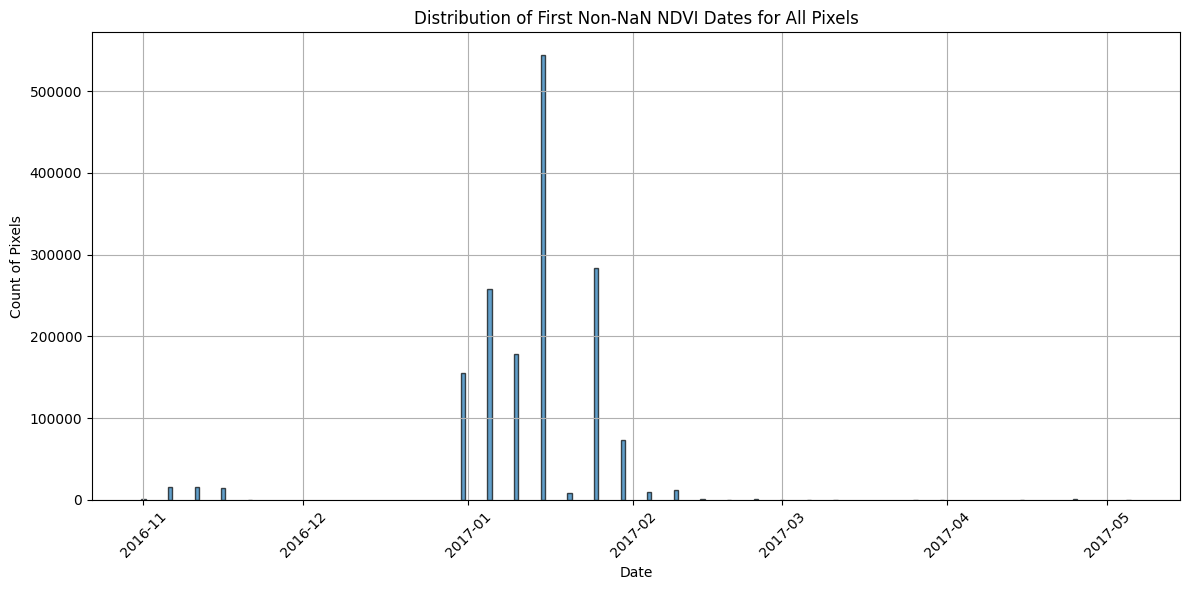

In [49]:
# List to store the first non-NaN time indices for all pixels
first_non_nan_indices = []

# Loop over all NetCDF files
for nc_file in nc_files:
    nc_path = os.path.join(file_path, nc_file)
    
    # Load the current NetCDF file
    data = xr.open_dataset(nc_path)
    ndvi_data = data['NDVI'].values
    
    # Get the size of the data
    time_len, x_len, y_len = ndvi_data.shape
    
    # Find the first non-NaN time index for each pixel
    for x in range(x_len):
        for y in range(y_len):
            first_non_nan_time_index = np.nan
            for t in range(time_len):
                if not np.isnan(ndvi_data[t, x, y]):
                    first_non_nan_time_index = t
                    break
            first_non_nan_indices.append(first_non_nan_time_index)

# Convert time indices to date values
start_date = pd.Timestamp('2016-01-01')
dates = [start_date + pd.Timedelta(days=int(index) * 5) for index in first_non_nan_indices if not np.isnan(index)]

# Count occurrences of each date
date_counts = pd.Series(dates).value_counts().sort_index()

# Plot the distribution of first non-NaN dates as a bar plot
plt.figure(figsize=(12, 6))
plt.bar(date_counts.index, date_counts.values, edgecolor='black', alpha=0.7)
plt.title('Distribution of First Non-NaN NDVI Dates for All Pixels')
plt.xlabel('Date')
plt.ylabel('Count of Pixels')
plt.grid(True)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()

In [50]:
# Calculate the median of the date values
median_date_num = np.median([date.toordinal() for date in dates])
median_date = pd.Timestamp.fromordinal(int(median_date_num))
median_date

Timestamp('2017-01-15 00:00:00')

In [51]:
max(dates)

Timestamp('2017-05-05 00:00:00')

Analyzing the distribution of non-NaN NDVI values over time reveals regular intervals during which fewer than 600,000 (of a possible 128 x 128 x 100 = 1,638,400 - so less than 40%) pixels show valid values for some measurement periods (every 5 days). This observation highlights the poor data quality and suggests that the prediction performance of our time series models will be significantly negatively affected by this substantial amount of missing data.

However, we have chosen to start our analysis from July 2017, as the first period of missing data (< 600k valid pixel values) ends here, and the next three measurement dates contain more than 1,000,000 valid pixels. As depicted by the red LOESS trend line in the graph, the number of valid pixels reaches a higher and more consistent level starting from this point, except for some subsequent periods with a low number of valid pixel values, particularly at the end of 2018 and the beginning of 2019.

Thus, we set our training period from July 4, 2017, to June 28, 2021, and the test period from July 3, 2021, to October 6, 2022. This ensures we have three complete seasonal cycles (apart from the periods with few data) available for training our models.


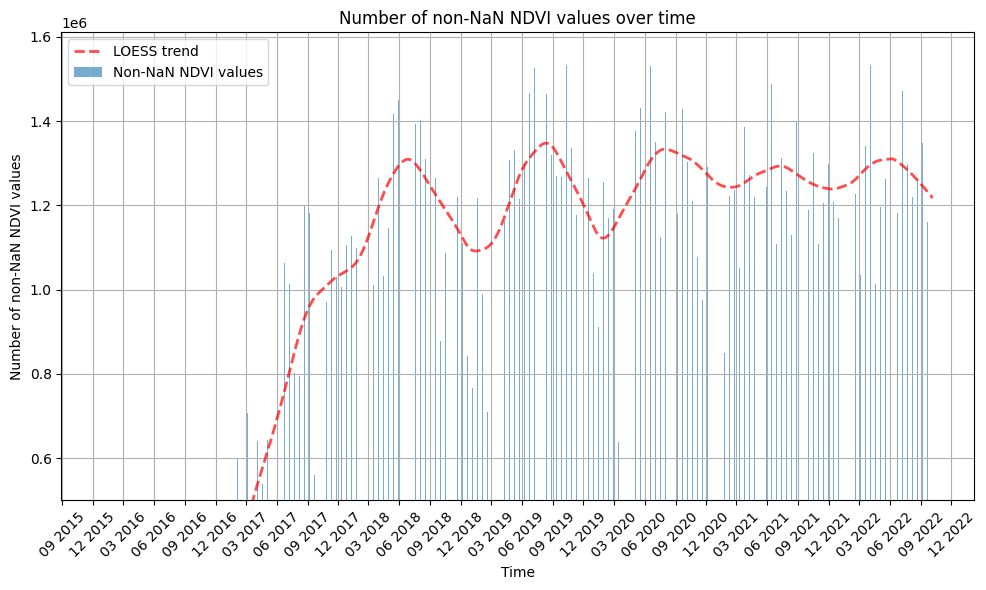

In [52]:
import matplotlib.dates as mdates
import statsmodels.api as sm

# Extract data for plotting
dates = list(results.keys())
non_nan_counts = list(results.values())

# Convert dates to a readable format if they are in string format
if isinstance(dates[0], str):
    dates = [np.datetime64(date) for date in dates]

# Convert dates to a numeric format for LOESS
numeric_dates = mdates.date2num(dates)

# Fit LOESS model
loess = sm.nonparametric.lowess(non_nan_counts, numeric_dates, frac=0.1)

# Plot the results as a histogram and a LOESS smoothed line
plt.figure(figsize=(10, 6))
plt.bar(dates, non_nan_counts, alpha=0.6, label='Non-NaN NDVI values')
plt.plot(dates, loess[:, 1], color='red', linewidth=2, linestyle='--', alpha=0.7, label='LOESS trend')

plt.xlabel('Time')
plt.ylabel('Number of non-NaN NDVI values')
plt.title('Number of non-NaN NDVI values over time')
plt.xticks(rotation=45)
plt.grid(True)

# Set x-axis to display quarterly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks to every 3 months (quarterly)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %Y'))  # Format the ticks to show the month and year

# Set y-axis lower bound to 500,000
plt.ylim(bottom=500000)

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.legend()
plt.show()


#### Perform Train and Test Split
In this step, we will split the time series data into separate train and test datasets for each cube.

In [53]:
# Define Output directories
output_folder_train = base_dir / "data" / "data_train"
output_folder_test = base_dir / "data" / "data_test"

In [ ]:
# Perform Train-Test Split and Save in Separate Files
for idx, nc_file in enumerate(nc_files, start=1):
    full_path = os.path.join(file_path, nc_file)
    
    # Load the NetCDF file
    dataset = xr.open_dataset(full_path)
    
    # Train-Test Split
    train_data = dataset.sel(time=slice('2017-07-04', '2021-06-28'))
    test_data = dataset.sel(time=slice('2021-07-03', '2022-10-06'))
    
    # Generate the new filenames and full paths for the output files
    base_filename = os.path.splitext(os.path.basename(nc_file))[0]  # Remove the .nc extension
    train_filename = os.path.join(output_folder_train, f'{base_filename}_train.nc')
    test_filename = os.path.join(output_folder_test, f'{base_filename}_test.nc')

    # Save Train and Test Data
    train_data.to_netcdf(train_filename)
    test_data.to_netcdf(test_filename)
 
    print(f"[{idx}/{len(nc_files)}] Train and test datasets saved for {os.path.basename(nc_file)}")


### Prepare Data for Final Training

Given the significant number of NaN values in our dataset and time series, we have decided to implement two distinct approaches to effectively handle these missing values.

**Approach A: Handling NaNs with Outliers and Cloud Mask Integration**

1. **Replace NaNs with an Outlier:**
   - We will replace NaN values with a clearly identifiable outlier value (e.g., -9999.0). This allows the model to recognize and handle these outliers during training.

2. **Use Cloud Mask as an Exogenous Feature:**
   - In addition, we will incorporate the cloud mask as an exogenous feature in our model. This helps the model learn the relationship between cloud coverage (as indicated by the cloud mask for a specific pixel during a specific time period) and the outlier value (-9999.0). This way, the model can understand that the -9999.0 value is likely due to cloud presence, improving its ability to make accurate predictions despite these outliers.

**Approach B: Interpolation with STL Decomposition**

1. **STL Interpolation:**
   - In this approach, we will use Seasonal-Trend decomposition using Loess (STL) to interpolate NaN values. STL decomposes the time series into seasonal, trend, and residual components, allowing for a more nuanced interpolation of missing values.

2. **Why Use STL Interpolation:**

   - **Captures Seasonal and Trend Components:**
     - STL is particularly effective for time series data with strong seasonal and trend components, which is the case for our NDVI data. By decomposing the data, STL can accurately interpolate missing values by considering the underlying seasonal patterns and long-term trends.

   - **Robust to Outliers:**
     - STL is robust to outliers and can provide a more reliable interpolation compared to simpler methods, which might be biased by irregularities in the data.

   - **Flexible and Adaptable:**
     - STL is flexible and can handle a wide range of time series characteristics, making it a versatile choice for our dataset with its complex patterns and missing values.


#### Prepare data for Approach A:

In [55]:
# Define input and output dirs
file_path = base_dir / "data" / "data_train"
output_path = base_dir / "data" / "data_A_9999"

In [ ]:
nc_files = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith('.nc')]

# Iterate over each .nc file and replace NaNs in the NDVI variable with -9999
for idx, nc_file in enumerate(nc_files, start=1):
    # Load the NetCDF file
    dataset = xr.open_dataset(nc_file)
    
    # Replace NaNs in the NDVI variable with -9999
    dataset['NDVI'] = dataset['NDVI'].fillna(-9999)
    
    # Generate the new filename and the full path for the output file
    output_file = os.path.join(output_path, f'ds_A_{os.path.basename(nc_file)}')
    
    # Save the modified dataset
    dataset.to_netcdf(output_file)
    
    print(f"[{idx}/{len(nc_files)}] Cube: {os.path.basename(nc_file)} | NaNs replaced and saved")


#### Prepare data for Approach B:
STL Interpolation

In [57]:
# Paths to the directory containing the NetCDF files
file_path = base_dir / "data" / "data_train"
output_path = base_dir / "data" / "data_B_interpolated"
os.makedirs(output_path, exist_ok=True)

In [ ]:
# List all NetCDF files in the input directory
nc_files = [f for f in os.listdir(file_path) if f.endswith('.nc')]

# Iterate over each file
for nc_file in nc_files:
    full_path = os.path.join(file_path, nc_file)
    ds = xr.open_dataset(full_path)
    
    interpolated_data = []
    
    # Iterate over each pixel and apply STL interpolation
    for x in ds.x:
        for y in ds.y:
            ndvi_pixel = ds['NDVI'].sel(x=x, y=y)
            if ndvi_pixel.isnull().all():
                # print(f"Pixel (x={x}, y={y}) contains only NaNs and will be skipped.")
                interpolated_data.append(np.full(ndvi_pixel.shape, np.nan))  # Append NaN array
            else:
                interpolated_ndvi = stl_interpolate(ndvi_pixel)
                interpolated_data.append(interpolated_ndvi.values)
    
    # Reshape the interpolated data to match the original dimensions
    interpolated_ndvi_array = np.array(interpolated_data).reshape((ds.sizes['x'], ds.sizes['y'], ds.sizes['time'])).transpose(2, 0, 1)
    
    # Create a new DataArray with the interpolated NDVI values
    interpolated_da = xr.DataArray(interpolated_ndvi_array, coords=[ds.time, ds.x, ds.y], dims=['time', 'x', 'y'], name='NDVI')
    
    # Create a new Dataset with the interpolated NDVI values and original attributes
    new_ds = xr.Dataset({'NDVI': interpolated_da, 'Cloud_Mask': ds['Cloud_Mask']}, coords=ds.coords, attrs=ds.attrs)
    
    # Save the new dataset to a NetCDF file
    output_file = os.path.join(output_path,  f'ds_B_{os.path.basename(nc_file)}')
    new_ds.to_netcdf(output_file)
    
    print(f"Interpolated file saved: {output_file}")

## Challenges in Data Preparation

The data preparation process was extremely time-consuming and challenging. This notebook is the final result of various approaches, ideas, and steps. A significant portion of our work involved experimenting with different strategies which do not appear in this notebook as they did not work out. We encountered several key challenges:

1. **Data Volume:** Initially, we started with approximately 5000 cubes. However, executing some steps, such as the initial NDVI calculation based on Sentinel-2 data, was infeasible due to limited computing power, leading to frequent process failures. Consequently, we reduced the dataset to 100 cubes, selecting those with the fewest missing values. Despite this reduction, many steps, like interpolating missing values, were time-intensive and often failed due to memory constraints, prolonging our work.

2. **Data Format:** None of us had prior experience with DataCubes, requiring time to understand the data format and how it was stored and loaded (see `src/data_processing/my_loader.py`). The lack of proper documentation for the DataLoader and MiniCubes meant we had to rely heavily on trial and error to correctly load the data in the desired format.

3. **Data Quality and Missing Data:** The dataset contained many missing values, attributed to Sentinel-2 data periods with missing band values and pixels masked by the cloud mask. After deliberation, we decided to exclude the entire year 2016 due to its extensive missing values, despite metadata indicating the measurement period started on January 1, 2016. Further investigation revealed periodic intervals with few valid pixel values, detrimental to time series prediction and definitely will negatively impact our models' predictive performance. To address missing values, we tested two approaches:
   - **Setting Missing Values to an Outlier:** Assigning missing values an extreme outlier value of -9999.0 (valid NDVI range: -1.0 to 1.0) and including the cloud mask as an exogenous factor to help the model learn the relationship between cloud presence and outliers. However the presence of clouds is not the only cause for missing values. They also occur without cloud indications.
   - **Interpolation of Missing Values:** Using STL decomposition for interpolation, specifically suitable for our data. This method was computationally and time-intensive. To avoid backward fill interpolation and accurately interpolate missing values, we restricted the time period to start from a point with relatively many valid pixels (July 4, 2017). Additionally, we decided to interpolate missing values only in the training data and evaluate model performance using actual test data (predicted vs. true test data), ignoring missing values in the test data to avoid distorting the evaluation metrics further.


## Challenges in Modelling

During the process of building the models, we encountered several problems. 

1. **Data for approach A**

    Procedure for the LSTM model:

    After the model was created and the predictions were made, the data was denormalized. When looking at the results, we noticed that all prediction results were disproportionately high (> 0.99). Due to the natural range of the NDVI from -1 to 1 and studying the baseline data, we concluded that the results are illogical and must be incorrect.
    Unfortunately, due to the limited time and the long processing times of the code, we were ultimately unable to determine the exact cause and find an appropriate solution. It is possible that the masking of the -9999 values did not work correctly, so that the -9999 values were regarded as “normal” values by the model. Incorrect normalization could also have been a possible reason.

    Due to the comparability, we then decided to completely exclude this data set for all models from our project. 

2. **Reducing Cubes: complete cubes**
   
   Furthermore, our initial aim was to use all 100 cubes for our project. This quickly proved to be impossible with the memory and computing power available to us. Despite the use of GPU, only very few cubes could be processed. We therefore had to reduce our data basis to 4 cubes. We sorted the 100 cubes in descending order of completeness. Complete means that the cube contains as few pixels as possible that contain NaN values across all timesteps. The 4 best cubes are therefore the following:
    1. Cube 665 
    2. Cube 80
    3. Cube 1203
    4. Cube 1301

3. **Trees in Random Forest**
    
    As with the other models, the Random Forest model also has considerable difficulties with processing time and memory capacity. Therefore, we were unfortunately not able to use more than one cube for the model. 